In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
import matplotlib.pyplot as plt

image_path = os.path.join("../CXR_png")
mask_path = os.path.join("../", "masks/")
clinical_path = os.path.join("../ClinicalReadings")

### We have 704 masks but 800 images. Hence we are going to make a 1-1 correspondance from mask to images, not the usual other way.

In [2]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
diags = os.listdir(clinical_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]
clinical_file_name = [fName.split(".txt")[0] for fName in mask]

check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:", len(check))

testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

Total mask that has modified name: 566


In [3]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    
    if flag == "test":
        for i in tqdm(testing_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
                        
            im_array.append(im)
            mask_array.append(mask)

        return im_array, mask_array

    if flag == "train":
        for i in tqdm(training_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]
            

            im_array.append(im)
            mask_array.append(mask)

        return im_array, mask_array

### Perform sanity check

In [4]:
def plotMask(X,y):
    sample = []

    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)

    for i in range(0, 6, 3):

        plt.figure(figsize=(25,10))

        plt.subplot(2, 3, 1+i)
        plt.imshow(sample[i])

        plt.subplot(2, 3, 2+i)
        plt.imshow(sample[i+1])


        plt.subplot(2, 3, 3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

### Load training and testing data

In [5]:
dim = 128*2

In [6]:
X_train, y_train = getData(dim, flag="train")

100%|██████████| 566/566 [01:21<00:00,  6.95it/s]


In [7]:
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:44<00:00,  3.10it/s]


training set


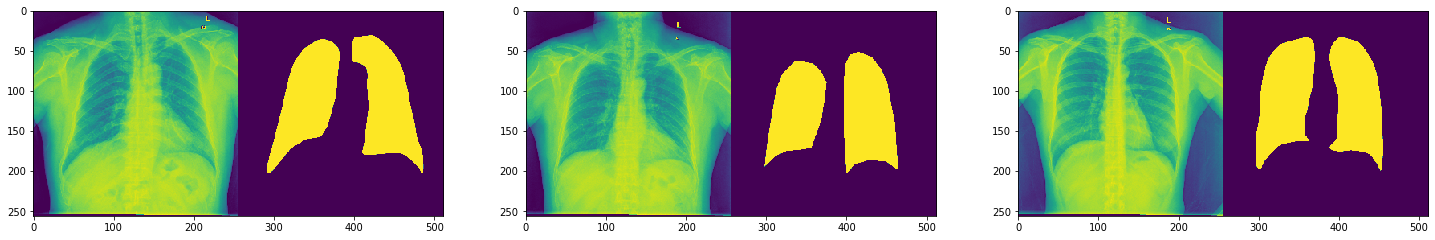

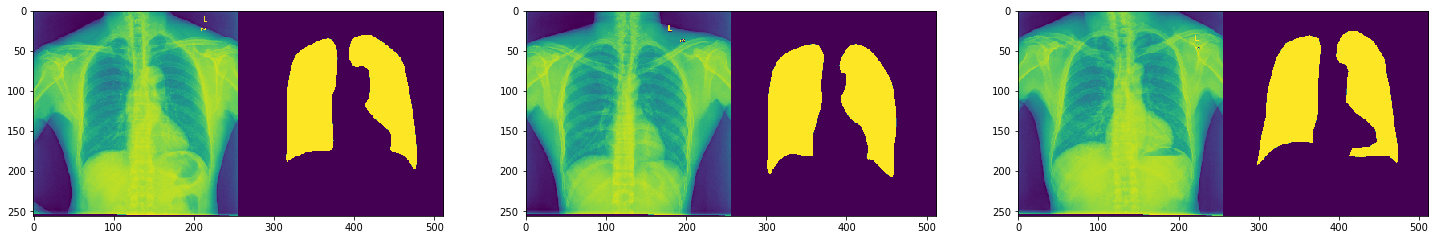

testing set


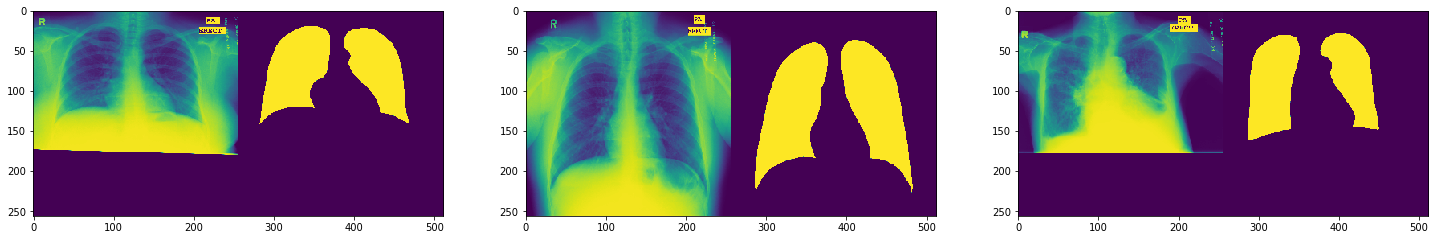

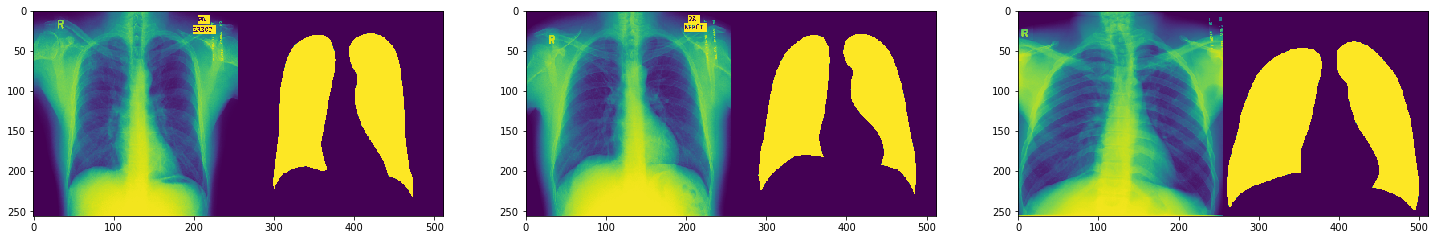

In [8]:
print("training set")
plotMask(X_train, y_train)
print("testing set")
plotMask(X_test, y_test)

In [9]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
y_train = np.array(y_train).reshape(len(y_train), dim, dim, 1)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
y_test = np.array(y_test).reshape(len(y_test), dim, dim, 1)

In [10]:
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape

In [11]:
images = np.concatenate((X_train, X_test), axis=0)
mask  = np.concatenate((y_train, y_test), axis=0)

### Preapare the neuron network U-Net model Tensorflow realization 

In [12]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(128,128,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


In [13]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
model.summary()






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', cooldown=2, min_lr=1e-6)
# reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                                    patience=3,
#                                    verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [15]:
from IPython.display import clear_output
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0,
                                                                        (mask>127).astype(np.float32),
                                                                        test_size=0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg,
                                                            test_size=0.1,
                                                            random_state=2018)

loss_history = model.fit(x=train_vol,
                         y=train_seg,
                         batch_size=8,
                         epochs=50,
                         validation_data =(test_vol, test_seg),
                         callbacks=callbacks_list)

# clear_output()




Train on 569 samples, validate on 64 samples
Epoch 1/50





569/569 [==============================] - 21s 38ms/step - loss: -0.4011 - dice_coef: 0.4011 - binary_accuracy: 0.3703 - val_loss: -0.5213 - val_dice_coef: 0.5213 - val_binary_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to -0.52133, saving model to cxr_reg_weights.best.hdf5
Epoch 2/50
569/569 [==============================] - 9s 16ms/step - loss: -0.8054 - dice_coef: 0.8054 - binary_accuracy: 0.8957 - val_loss: -0.8531 - val_dice_coef: 0.8531 - val_binary_accuracy: 0.9334

Epoch 00002: val_loss improved from -0.52133 to -0.85309, saving model to cxr_reg_weights.best.hdf5
Epoch 3/50
569/569 [==============================] - 9s 16ms/step - loss: -0.8985 - dice_coef: 0.8985 - binary_accuracy: 0.9494 - val_loss: -0.9083 - val_dice_coef: 0.9083 - val_binary_accuracy: 0.9564

Epoch 00003: val_loss improved from -0.85309 to -0.90826, saving model to cxr_reg_weights.best.hdf5
Epoch 4/50
569/569 [===================

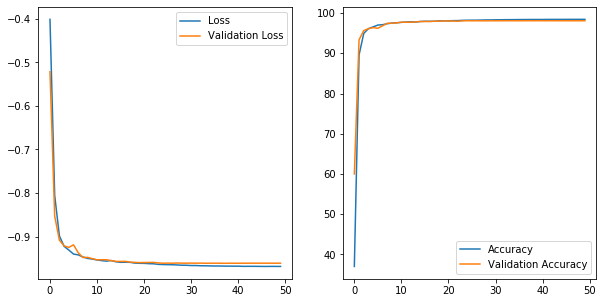

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(loss_history.history['loss'], '-', label='Loss')
ax1.plot(loss_history.history['val_loss'], '-', label='Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-',
         label='Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label='Validation Accuracy')
ax2.legend()
pred_candidates = np.random.randint(1, validation_vol.shape[0], 10)

In [25]:
# with tf.Session() as sess:
#     with tf.device("/cpu:1"):
preds = model.predict(validation_vol)

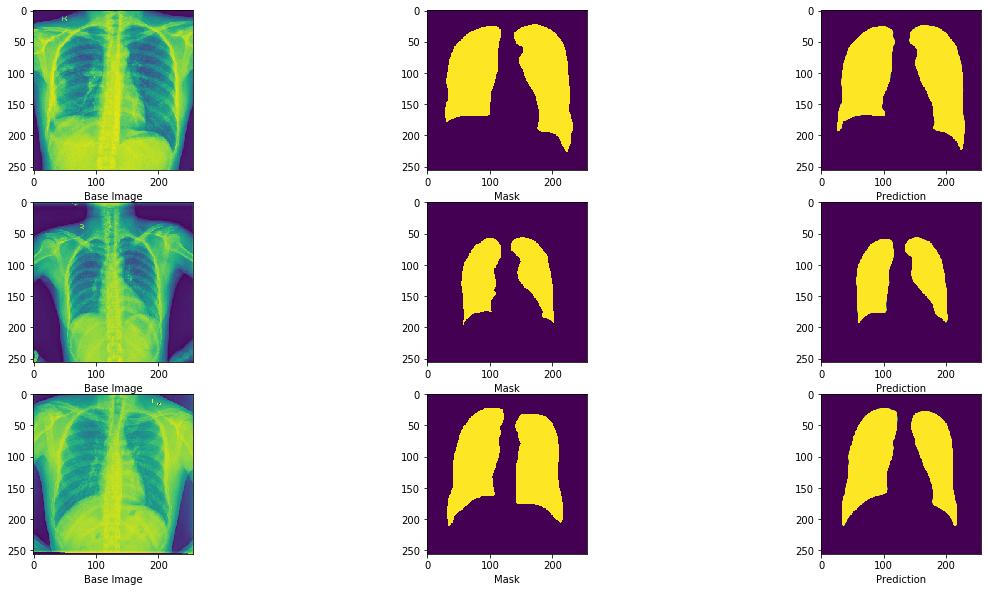

In [26]:
plt.figure(figsize=(20, 10))

for i in range(0, 9, 3):
    plt.subplot(3, 3, i+1)

    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")


    plt.subplot(3, 3, i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")

    plt.subplot(3, 3, i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")